## Question 1. "Projection on a Euclidean ball" problem

In [0]:
import numpy as np
import numpy.linalg as nla
import cvxpy as cp
import pandas as pd
import random

# import scipy.sparse as sps
# import networkx

from scipy.interpolate import interp1d
import scipy.sparse
from scipy.optimize import linprog

import matplotlib.pyplot as plt

In [0]:
def make_noise(a, b, n, noise, kind, label):
    x = np.linspace(a, b, 20)
    y = -np.sin(x**2)
    inter = interp1d(x, y, kind=kind)
    x_new = np.linspace(a, b, n)
    f = inter(x_new)
    f_noised = f + noise

    plt.figure(figsize=(8, 4))
    plt.plot(x, y, 'o', x_new, f, '-')
    plt.title(label)
    plt.grid(True)

    return f_noised

In [0]:
def solve_problem(n, f_noise):
    f = cp.Variable(n)
    regs = [cp.power(cp.norm(D1*f, p=2), 2), cp.norm(D1*f, p=1), cp.norm(D2*f, p=1)]
    f_vals = []

    for reg in regs:
      func = cp.power(cp.norm(f - f_noise, p=2), 2) + reg
      problem = cp.Problem(cp.Minimize(func))
      problem.solve()
      f_vals.append(f.value)

    return f_vals

In [0]:
def plot_regs(n, funcs, name):
    fig, ax = plt.subplots(2, 2, figsize=(18, 8))
    penalties = ["noised", "$||D_1\hat{x}||_2$", "$||D_1\hat{x}||_1$", "$||D_2\hat{x}||_1$"]
    for i, (y, penalty) in enumerate(zip(funcs, penalties)):
        x = np.linspace(a, b, n)
        ax[int(i/2)][i%2].plot(x, y)
        ax[int(i/2)][i%2].set_title(name + " " + penalty)
        ax[int(i/2)][i%2].grid(True)
    plt.show()

In [0]:
n = 1000
a = 0
b = 10
noise = 0.1*np.random.randn(n)
D1 = scipy.sparse.diags([1, -1], [0, 1], shape=(n-1, n)).toarray()
D2 = scipy.sparse.diags([1, -2, 1], [0, 1, 2], shape=(n-2, n)).toarray()

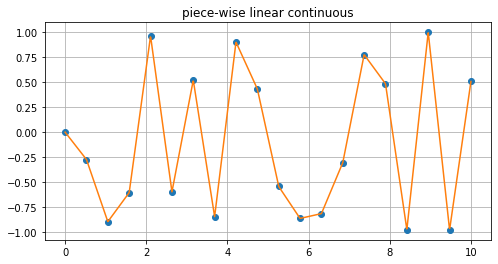

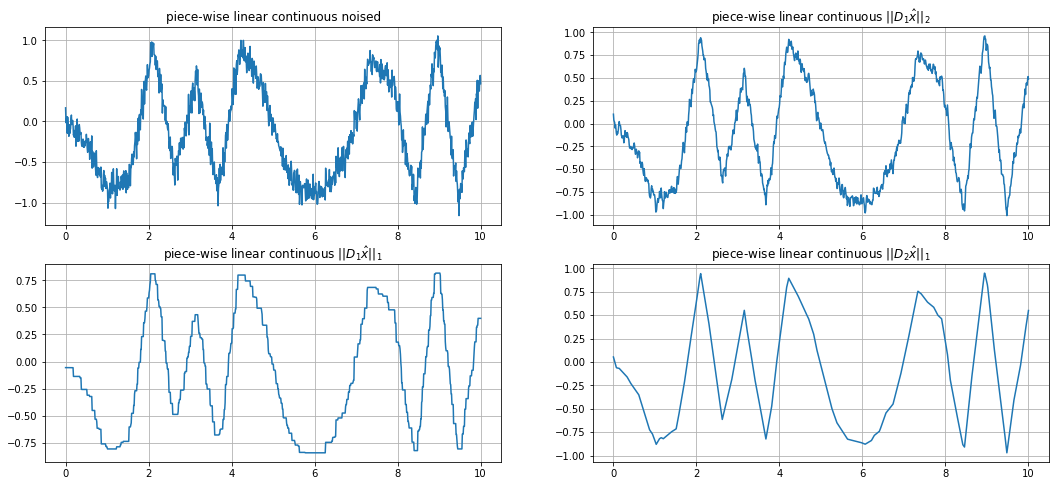

In [6]:
label = 'piece-wise linear continuous'
f_cont_noise = make_noise(a, b, n, noise, 'linear', label)
f_vals = solve_problem(n, f_cont_noise)
plot_regs(n, [f_cont_noise, f_vals[0], f_vals[1], f_vals[2]], label)

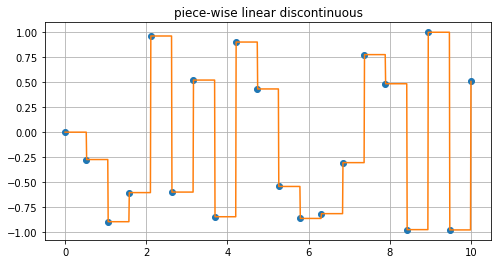

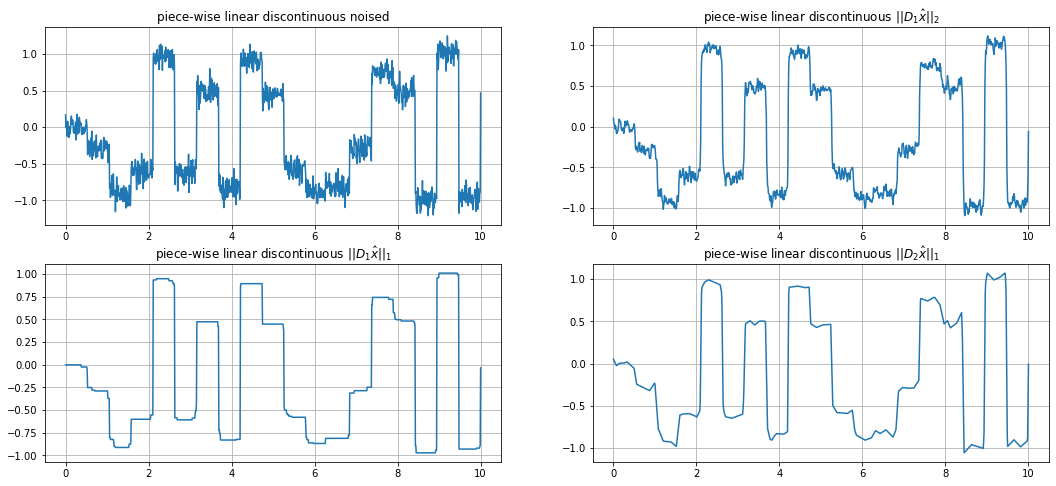

In [7]:
label = 'piece-wise linear discontinuous'
f_discont_noise = make_noise(a, b, n, noise, 'zero', label)
f_vals = solve_problem(n, f_discont_noise)
plot_regs(n, [f_discont_noise, f_vals[0], f_vals[1], f_vals[2]], label)

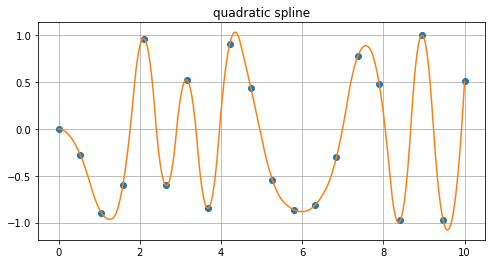

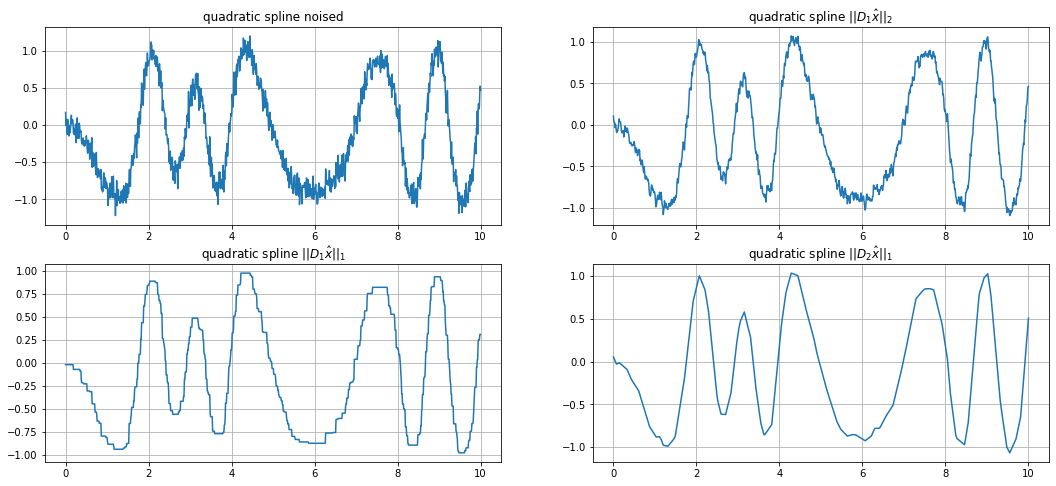

In [8]:
label = 'quadratic spline'
f_quad_noise = make_noise(a, b, n, noise, 'quadratic', label)
f_vals = solve_problem(n, f_quad_noise)
plot_regs(n, [f_quad_noise, f_vals[0], f_vals[1], f_vals[2]], label)

## 4.

In [0]:
def calc_penalty(f_noise):
    residual, penalty = [], []
    for gamma in np.logspace(-4, 4, 30):
        f = cp.Variable(n)
        regs = [cp.power(cp.norm(D1*f, p=2), 2), cp.norm(D1*f, p=1), cp.norm(D2*f, p=1)]
        func = cp.power(cp.norm(f - f_noise, p=2), 2) + gamma*regs[2]
        problem = cp.Problem(cp.Minimize(func))
        problem.solve()
        residual.append([np.linalg.norm(f.value - f_noise, 2)])
        penalty.append([np.linalg.norm(D2.dot(f.value), 1)])

    return residual, penalty

In [0]:
def plot_penalty(x, y, name):
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, 'o-', markersize=4)
    plt.title(name)
    plt.xlabel(r"$||y-\hat{x}||_1$")
    plt.ylabel(r"$||D_2\hat{x}||_1$")
    plt.grid(True)
    # plt.xscale("log")
    plt.show()

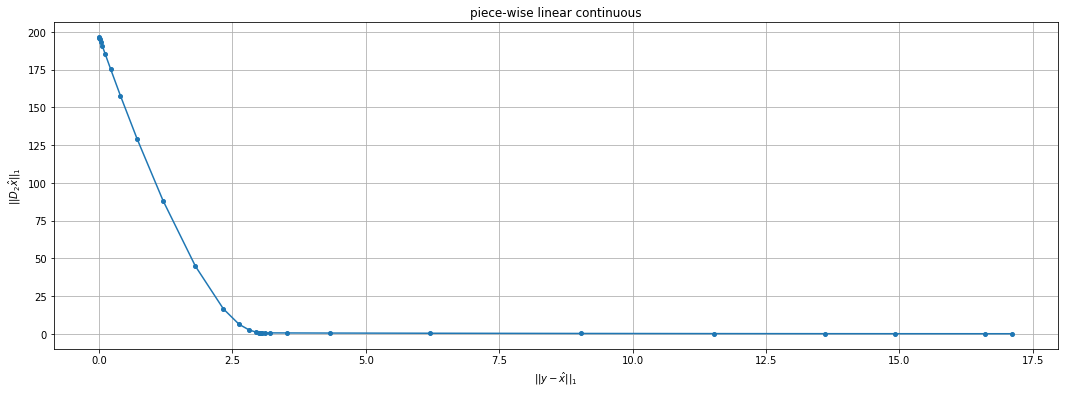

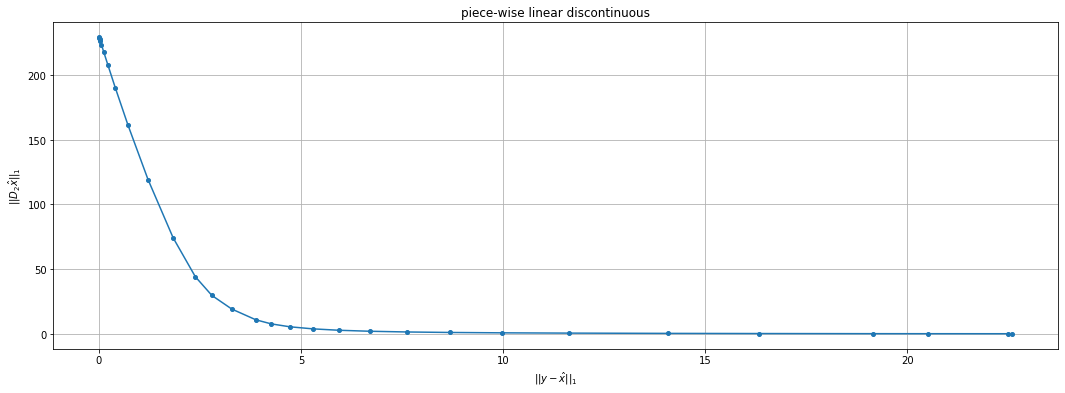

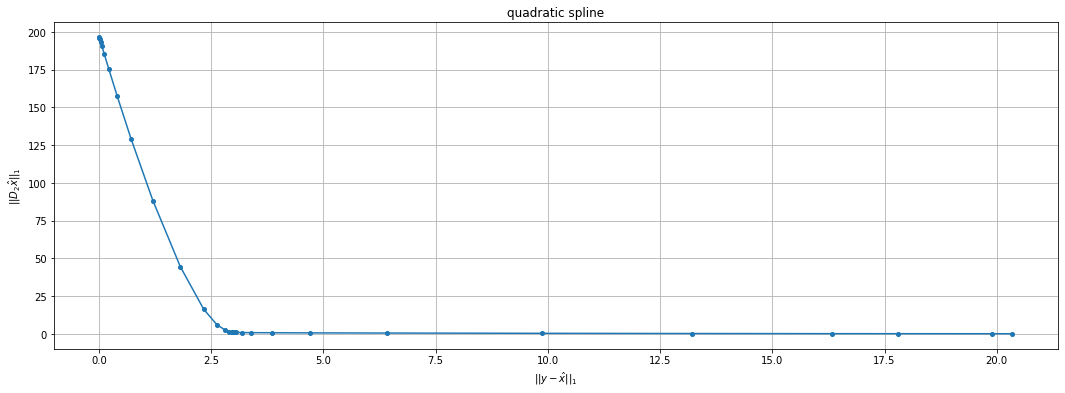

In [11]:
f_noised = [f_cont_noise, f_discont_noise, f_quad_noise]
names = ["piece-wise linear continuous", "piece-wise linear discontinuous", "quadratic spline"]

for f_noise, name in zip(f_noised, names):
    residual, penalty = calc_penalty(f_noise)
    plot_penalty(residual, penalty, name)

For piece-wise linear continuous function the optimal $\gamma\approx 2.7$.

For piece-wise linear discontinuous function the optimal $\gamma\approx 3.3$.

For quadratic spline function the optimal $\gamma\approx 2.7$.

## Question 2. SDP and Schur complement

$X=\begin{pmatrix} 
A & B\\
B^T & C\\
\end{pmatrix} \geq 0$

$X>0 <=> A>0, C−B^TA^{−1}B>0$.

$a \in \mathcal {E} = \left\{x:(x-c)^T P^{-1}(x-c) \leq 1 \right\} \Rightarrow$

$(a-c)^T P^{-1}(a-c) \leq 1 \Rightarrow$

$1-(a-c)^T P^{-1}(a-c) \geq 0$.

Schur complement with $C = I_1$ $(1\times 1)$:

$I_1-(a-c)^T P^{-1}(a-c) \geq 0 \Rightarrow$

$X=\begin{pmatrix} 
P & a-c\\
(a-c)^T & 1\\
\end{pmatrix} \geq 0$.

## Question 3. Goemans-Willamson relaxation

$L = D_G − A_G -$ is the Laplacian matrix of the graph

$D -$ is the degree matrix of the graph (diagonal)

$A -$ is the adjacency matrix of the graph (symmetric, 1 or 0, diagonal 0)

In [12]:
n = 20
U = np.triu(np.random.binomial(1, 0.85, size=(n,n)), k=1)
A = U + U.T
D = A.sum(axis=0)
L = np.diag(D) - A
D.mean()/n

0.825

### 1. Naive randomization

$\max x^TLx$

$s.t. x_i^2-1=0, i=1, ..., n$

In [0]:
N = 1000
xs = np.random.choice([-1, 1], size=(N, n))
fs = [x.T@L@x for x in xs]

### 2. Solution of SDP relaxation

$x^TLx=tr(x^TLx)=tr(Lxx^T)=tr(LX) \Rightarrow$

$X = xx^T -$ rank $1$

$\max tr(LX)$

$s.t. X_{ii}=1, X \geq 0$

In [14]:
X = cp.Variable((n,n), symmetric=True)
constraints = [X>>0] + [X[i,i] == 1 for i in range(n)]
prob = cp.Problem(cp.Maximize(cp.trace(L @ X)), constraints)
prob.solve()
spd_value = prob.value
spd_value

391.1683440624029

### 3. Goemans-Williamson approximation

In [0]:
V = nla.cholesky(X.value+1e-3*np.eye(n)).T
ksi = np.random.randn(N, n)
xx = np.sign(ksi @ V)
fxx = [xi.T@L@xi for xi in xx]

### 4. Mathematical expectation

$\mathop{{}\mathbb{E}}ξ(\widetilde x^TL\widetilde x)$

In [0]:
fxx_mean = np.mean(fxx)

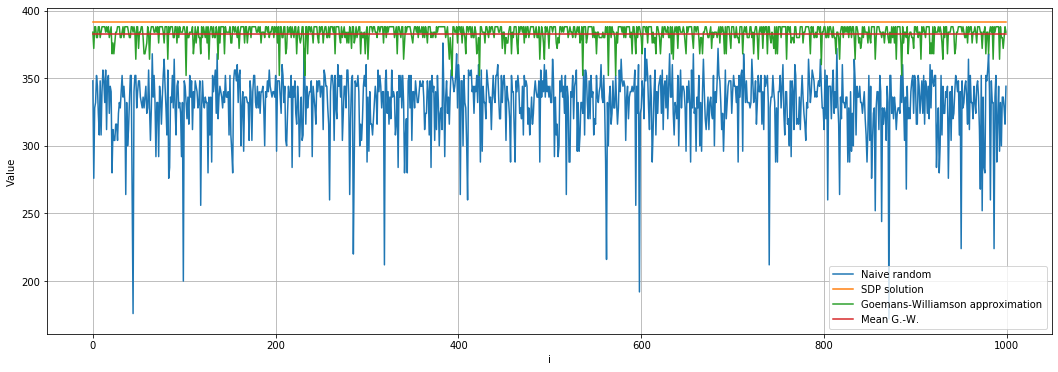

In [18]:
plt.figure(figsize=(18, 6))

plt.plot(fs, label="Naive random")
plt.plot([spd_value]*N, label="SDP solution")
plt.plot(fxx, label="Goemans-Williamson approximation")
plt.plot([fxx_mean]*N, label="Mean G.-W.")

plt.ylabel("Value")
plt.xlabel("i")
plt.grid(True)
plt.legend();

## Problem 4.

### 1. The problem formulation:

We have 4 cargos (1, 2, 3, 4) and 3 compartments (a, b, c). So, we have 3*4=12 variables.

1) We want to maximize the profit:

$c = 310(w_{1a} + w_{1b} + w_{1c}) + 380(w_{2a} + w_{2b} + w_{2c}) + 350(w_{3a} + w_{3b} + w_{3c}) + 285(w_{4a} + w_{4b} + w_{4c})$

2) Inequality constraints:

Cargoes weight constraints:

$\begin{cases}
w_{1a} + w_{2a} + w_{3a} + w_{4a} \leq 10 \\
w_{1b} + w_{2b} + w_{3b} + w_{4b} \leq 16 \\
w_{1c} + w_{2c} + w_{3c} + w_{4c} \leq 8 \\
\end{cases}$

Compartments weight capacity constraints:

$\begin{cases}
w_{1a} + w_{1b} + w_{1c} \leq 18 \\
w_{2a} + w_{2b} + w_{2c} \leq 15 \\
w_{3a} + w_{3b} + w_{3c} \leq 23 \\
w_{4a} + w_{4b} + w_{4c} \leq 12
\end{cases}$

Compartments volume capacity constraints:

$\begin{cases}
480w_{1a} + 650w_{2a} + 580w_{3a} + 390w_{4a} \leq 6800 \\
480w_{1b} + 650w_{2b} + 580w_{3b} + 390w_{4b} \leq 8700 \\
480w_{1c} + 650w_{2c} + 580w_{3c} + 390w_{4c} \leq 5300
\end{cases}$

3) Equality constraints:

Cargoes weight constraints:

$\begin{cases}
\frac{w_{1a} + w_{2a} + w_{3a} + w_{4a}}{10} - \frac{w_{1b} + w_{2b} + w_{3b} + w_{4b}}{16} = 0\\
\frac{w_{1b} + w_{2b} + w_{3b} + w_{4b}}{16} - \frac{w_{1c} + w_{2c} + w_{3c} + w_{4c}}{8} = 0 \\
\frac{w_{1a} + w_{2a} + w_{3a} + w_{4a}}{10} - \frac{w_{1c} + w_{2c} + w_{3c} + w_{4c}}{8}= 0
\end{cases}$

4) So,

$A_{ub}=\begin{pmatrix}
1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1\\
1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1\\
480 & 650 & 580 & 390 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 480 & 650 & 580 & 390 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 480 & 650 & 580 & 390
\end{pmatrix}$

$b_{ub}^T=\begin{pmatrix}
10 & 16 & 8 & 18 & 151 & 23 & 12 & 6800 & 8700 & 5300
\end{pmatrix}$

$A_{eq}=\begin{pmatrix}
\frac{1}{10} & \frac{1}{10} & \frac{1}{10} & \frac{1}{10} & 0 & 0 & 0 & 0 & -\frac{1}{16} & -\frac{1}{16} & -\frac{1}{16} & -\frac{1}{16}\\
0 & 0 & 0 & 0 & -\frac{1}{16} & -\frac{1}{16} & -\frac{1}{16} & -\frac{1}{16} & 0 & 0 & 0 & 0\\
\frac{1}{10} & \frac{1}{10} & \frac{1}{10} & \frac{1}{10} & 0 & 0 & 0 & 0 & -\frac{1}{8} & -\frac{1}{8} & -\frac{1}{8} & -\frac{1}{8}\\
\end{pmatrix}$

$b_{eq}^T=\begin{pmatrix}
0 & 0 & 0
\end{pmatrix}$

Linear program:

$\min -c^Tx$

s.t. $A_{ub} x \leq b_{ub}$, $A_{eq}x = b_{eq}$

### 2. Assumptions:
Each cargo can be divided to any parts in any proportions and distributed to one, two or three compartments simultaniously.

In [0]:
weight_cap = np.array([10, 16, 8])
space_cap = np.array([6800, 8700, 5300])

weights = np.array([18, 15, 23, 12])
volumes_per_w = np.array([480, 650, 580, 390])
profits_per_w = np.array([310, 380, 350, 285])

In [20]:
r1 = np.hstack((np.ones(4), np.zeros(8))) # <= 10
r2 = np.roll(r1, 4) # <= 16
r3 = np.roll(r2, 4) # <= 8

tmp = np.hstack(([1], np.zeros(3)))
r4 = np.hstack((tmp, tmp, tmp)) # <= 18 
r5 = np.roll(r4, 1) # <= 15
r6 = np.roll(r5, 1) # <= 23
r7 = np.roll(r6, 1) # <= 12

r8 = np.hstack((volumes_per_w, np.zeros(8))) # <= 6800
r9 = np.roll(r8, 4) # <= 8700
r10 = np.roll(r9, 4) # <= 5300

A_ub = np.vstack((r1, r2, r3, r4, r5, r6, r7, r8, r9, r10))
b_ub = np.hstack((weight_cap, weights, space_cap)).astype(np.float64)
A_ub, b_ub

(array([[  1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,
           0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
           1.],
        [  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
           0.],
        [  0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
           0.],
        [  0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
           0.],
        [  0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
           1.],
        [480., 650., 580., 390.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  0.,   0.,   0.,   0., 480., 650., 580., 390.,   0.,   0.,   0.,
           0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 480., 650., 580.,
         390.]]),
 array([1.0e+01, 1.6e+01, 8.0e+00, 1.8e+01, 1.5e+01, 2.3e+01, 1.2e+01,
        6.8e+03, 

In [21]:
eq1 = np.hstack((np.ones(4)/weight_cap[0], -np.ones(4)/weight_cap[1], np.zeros(4)))
eq2 = np.hstack((np.zeros(4), np.ones(4)/weight_cap[1], -np.ones(4)/weight_cap[2]))
eq3 = np.hstack((np.ones(4)/weight_cap[0], np.zeros(4), -np.ones(4)/weight_cap[2]))

A_eq = np.vstack((eq1, eq2, eq3))
b_eq = np.zeros(3)
A_eq, b_eq

(array([[ 0.1   ,  0.1   ,  0.1   ,  0.1   , -0.0625, -0.0625, -0.0625,
         -0.0625,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.0625,  0.0625,  0.0625,
          0.0625, -0.125 , -0.125 , -0.125 , -0.125 ],
        [ 0.1   ,  0.1   ,  0.1   ,  0.1   ,  0.    ,  0.    ,  0.    ,
          0.    , -0.125 , -0.125 , -0.125 , -0.125 ]]), array([0., 0., 0.]))

In [0]:
c = -np.hstack((profits_per_w, profits_per_w, profits_per_w)) # maximize
bounds = [(0, weights[0]), (0, weights[1]), (0, weights[2]), (0, weights[3]), (0, weights[0]), (0, weights[1]), (0, weights[2]), (0, weights[3]), (0, weights[0]), (0, weights[1]), (0, weights[2]), (0, weights[3])]

In [23]:
result0 = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
xx0 = result0["x"].reshape(3,4).sum(axis=0)
delta0 = np.round(result0["slack"], 2)
result0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  """Entry point for launching an IPython kernel.


     con: array([-1.22753918e-10,  2.04961270e-10,  8.22073520e-11])
     fun: -12151.578940698348
 message: 'Optimization terminated successfully.'
     nit: 9
   slack: array([4.50853932e-09, 9.17772347e-09, 2.94917157e-09, 1.80000000e+01,
       9.26466015e-09, 7.05263160e+00, 8.94736842e+00, 3.91967217e+02,
       5.59981891e-06, 2.18032790e+02])
  status: 0
 success: True
       x: array([3.80564680e-09, 8.68618267e+00, 1.31381732e+00, 2.57358299e-09,
       2.67199728e-09, 2.10280443e-11, 1.29473684e+01, 3.05263158e+00,
       1.76261934e-09, 6.31381732e+00, 1.68618267e+00, 1.06263194e-09])

### 4. Sensitivity to the constraint values

If available cargoes weight decreases by 10%:

In [24]:
b_ub1 = np.array(b_ub)
b_ub1[3:-3] *= 0.9
result1 = linprog(c, A_ub=A_ub, b_ub=b_ub1, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
xx1 = result1["x"].reshape(3,4).sum(axis=0)
delta1 = np.round(result1["slack"], 2)
result1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  This is separate from the ipykernel package so we can avoid doing imports until


     con: array([-2.86840551e-11,  4.73751594e-11,  1.86909654e-11])
     fun: -12106.578945822697
 message: 'Optimization terminated successfully.'
     nit: 8
   slack: array([1.03578657e-09, 2.11620232e-09, 6.79101220e-10, 1.62000000e+01,
       2.37569253e-09, 3.25263158e+00, 7.74736842e+00, 4.34404472e+02,
       1.32147761e-06, 2.80595529e+02])
  status: 0
 success: True
       x: array([6.26472541e-10, 8.07993612e+00, 1.92006388e+00, 6.10637430e-10,
       4.67172678e-11, 1.17618942e-10, 1.29473684e+01, 3.05263158e+00,
       3.71877209e-10, 5.42006388e+00, 2.57993612e+00, 2.87289572e-10])

If available cargoes weight increases by 10%:

In [25]:
b_ub2 = np.array(b_ub)
b_ub2[3:-3] *= 1.1
result2 = linprog(c, A_ub=A_ub, b_ub=b_ub2, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
xx2 = result2["x"].reshape(3,4).sum(axis=0)
delta2 = np.round(result2["slack"], 2)
result2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  This is separate

     con: array([-1.13288023e-09, -1.02847297e-09, -2.16135319e-09])
     fun: -12196.578942611268
 message: 'Optimization terminated successfully.'
     nit: 12
   slack: array([-7.09964354e-09,  6.76664946e-09,  1.16111085e-08,  1.98000000e+01,
        1.92209662e-08,  1.08526316e+01,  1.01473684e+01,  3.43396908e+02,
        4.09828317e-06,  1.61603096e+02])
  status: 0
 success: True
       x: array([7.28564740e-10, 9.38004411e+00, 6.19955892e-01, 2.65068731e-10,
       3.62606217e-09, 4.53260195e-11, 1.29473684e+01, 3.05263158e+00,
       1.89567480e-09, 7.11995587e+00, 8.80044120e-01, 4.53971215e-10])

The cargo weight distribution among the compartments:

In [26]:
I = pd.Index(["0", "-10%", "+10%", "profit / w"])
pd.DataFrame(np.round(np.vstack((xx0, xx1, xx2, profits_per_w)), 2), index=I, columns=['C1', 'C2', 'C3', 'C4'])

,C1,C2,C3,C4
0,0.0,15.0,15.95,3.05
-10%,0.0,13.5,17.45,3.05
+10%,0.0,16.5,14.45,3.05
profit / w,310.0,380.0,350.00,285.00


So, we can see that C1 is not used, amount of C4 is constant, amount of C2 increases with the available weight increase, and amount of C3 decreases with the available weight increase. It corresponds the fact that the 2nd and the 3rd cargoes are the most expensive.

Let's look at 10 inequality conditions we have:

$Slack = b_{ub} - A_{ub}x$

In [27]:
pd.DataFrame(np.vstack(((b_ub, delta0, delta1, delta2))).T, columns=['b_ub[i]', 'slack, 0', 'slack, -10%', 'slack, +10%'])

,b_ub[i],"slack, 0","slack, -10%","slack, +10%"
0,10.0,0.00,0.00,-0.00
1,16.0,0.00,0.00,0.00
2,8.0,0.00,0.00,0.00
3,18.0,18.00,16.20,19.80
4,15.0,0.00,0.00,0.00
5,23.0,7.05,3.25,10.85
6,12.0,8.95,7.75,10.15
7,6800.0,391.97,434.40,343.40
8,8700.0,0.00,0.00,0.00
9,5300.0,218.03,280.60,161.60


Where $slack = 0$, the condition is fully used (weight or volume is fully occupied). We see the same picture with the cargoes weights. Also, the 2nd compartment is fully used, the 1st and the 3rd are used proportionally.